# Trabajo Práctico N°2: Modelo de predicción de precios de propiedades 

## Desafío 2. Modelo para el calculo del precio por m2 de propiedades

Grupo Nª2
Alumnos:
* Alberto Paparelli
* André Song
* Marianela Riz
* Gloria Caravajal
* Franco Emanuel Rodriguez

Objetivos:
● Seleccionar los datos a modelar. Justificar esa selección.
● Entrenar al menos tres modelos de regresión lineal distintos sobre estos datos.
● Evaluar la performance de los modelos y comparar ventajas y desventajas de cada
uno.
● Determinar la importancia de las features incluidas en la predicción. Interpretar.

## MODELOS A DESARROLLAR

1- Modelo para apartamentos de Capital Federal

2- Modelo para apartamentos nuevas de Capital Federal

3- Modelo para apartamentos usadas de Capital Federal

4- Modelo regularizado (lasso y rich) para apartamentos usados de Capital Federal

5- Modelo aplicado para casas usadas de capital Federal


# Importación de librerias

In [74]:
#importamos librerias para tratamiento de datos
import numpy as np
import pandas as pd
import re
import math as mat

#importamos librerias la visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
%matplotlib inline

## Cargue del Dataframe de Capital Federal

Hemos seleccionado este State_name porqué aunque con la limpieza se perdieron algunos datos, sigue teniendo una cantidad importante de datos.
Adicionalmente, estos datos ya traen consigo la información en los Place_name de los barrios de la Capital Federal, que puede ser una variable explicativa del precio del metro cuadrado de las propiedades.

In [81]:
filename = "../dataset/capital.csv"
data_original = pd.read_csv(filename, sep=',')
display(data_original.sample(n=2))
print(f"(Cantidad de Filas, Cantidad de columnas) -> {data_original.shape}")

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
1954,1954,1955,apartment,Almagro,1640939,93000,30,30,3100,3100,2,2,0,0,0,0,0,"Departamento 2 AMBIENTES, muy luminoso. Living...",GASCON 1100 // MUY LUMINOSO
8283,8283,8284,apartment,Caballito,3176010,180000,57,55,3158,3273,3,3,0,0,0,1,0,Excelente semipiso de 3 ambientes al frente co...,Venta Semipiso Caballito 3 Ambientes al Frente...


(Cantidad de Filas, Cantidad de columnas) -> (16938, 19)


In [82]:
data=data_original[(data_original.property_type=="apartment")]
data.sample()
data.shape

(14222, 19)

Vamos a eliminar las columnas que no vamos a emplear para desarrollar los modelos: Description y Title

In [83]:
data.drop([data.columns[0],"numero","description","price_aprox_local_currency","price_per_m2" ,"title", "price_usd_per_m2", "property_type"], axis=1,inplace=True)
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14222 entries, 0 to 16937
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   place_name             14222 non-null  object
 1   price_aprox_usd        14222 non-null  int64 
 2   surface_total_in_m2    14222 non-null  int64 
 3   surface_covered_in_m2  14222 non-null  int64 
 4   floor                  14222 non-null  int64 
 5   rooms                  14222 non-null  int64 
 6   expenses               14222 non-null  int64 
 7   piscina                14222 non-null  int64 
 8   Parrilla               14222 non-null  int64 
 9   Cochera                14222 non-null  int64 
 10  nuevo                  14222 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 1.3+ MB


c:\Users\usuario\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Hacemos un último chequeo para que no tengamos nans en la columnas con las que vamos a trabajar

In [84]:
data.isna().sum()

place_name               0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
floor                    0
rooms                    0
expenses                 0
piscina                  0
Parrilla                 0
Cochera                  0
nuevo                    0
dtype: int64

Creamos un grupo de variables númericas empleando. describe, tambien chequemos los valores minimos y máximos de las variables.

In [85]:
num=data.describe()
num

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
count,1.422200e+04,14222.000000,14222.000000,14222.000000,14222.000000,1.422200e+04,14222.000000,14222.000000,14222.00000,14222.000000
mean,3.097935e+05,76.197792,66.947687,2.727535,2.360990,2.277645e+04,0.296653,0.335255,0.38799,0.502602
std,5.003292e+05,61.726580,62.181870,2.433753,1.329184,1.186171e+06,0.456798,0.472096,0.48731,0.500011
min,5.500000e+03,10.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,1.060000e+05,40.000000,36.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
50%,1.572190e+05,55.000000,48.000000,2.000000,2.000000,0.000000e+00,0.000000,0.000000,0.00000,1.000000
75%,2.950000e+05,87.000000,75.000000,4.000000,3.000000,1.000000e+01,1.000000,1.000000,1.00000,1.000000
max,1.133952e+07,789.000000,3673.000000,27.000000,15.000000,1.000150e+08,1.000000,1.000000,1.00000,1.000000


Graficamos box plots para revisar si tenemos outliers dentro de las variables que puedan afectar la predicción

In [ ]:
#sns.catplot(data=data, x= 'price_aprox_usd', y="property_type", kind="box", height=5, aspect=5,)

<AxesSubplot:>

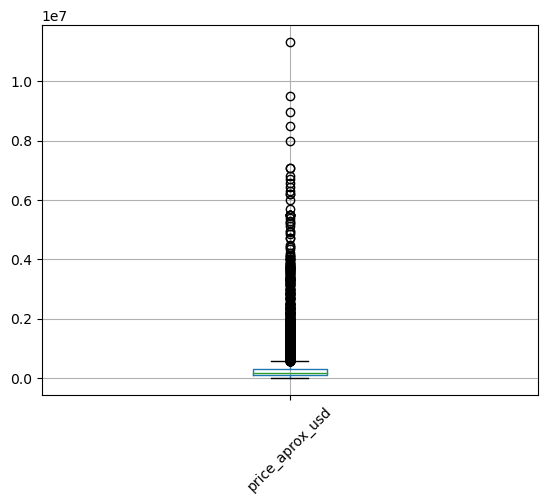

In [86]:
data.boxplot(column=list(num.columns)[:1],rot=45) 

<AxesSubplot:>

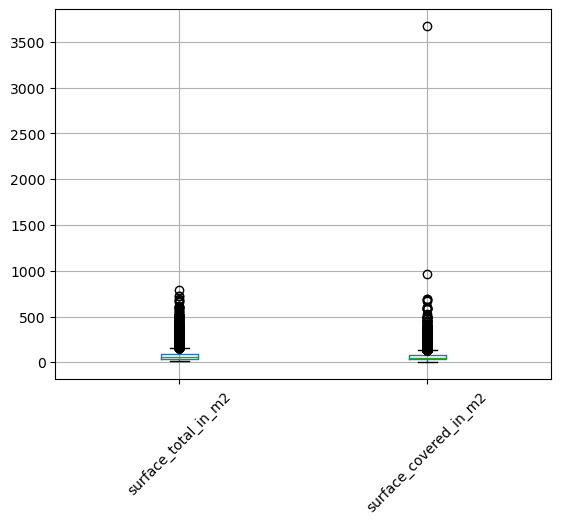

In [87]:
data.boxplot(column=list(num.columns)[1:3],rot=45) 

<AxesSubplot:>

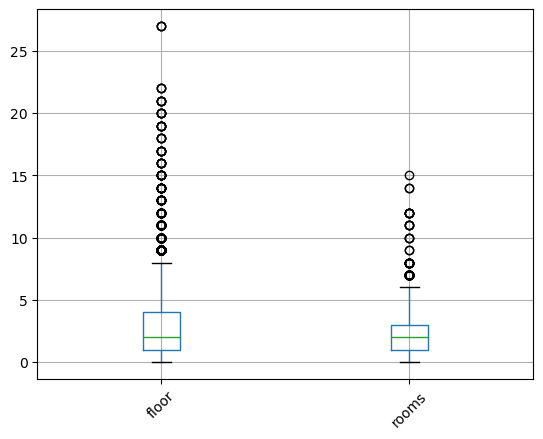

In [88]:
data.boxplot(column=list(num.columns)[3:5],rot=45) 

<AxesSubplot:>

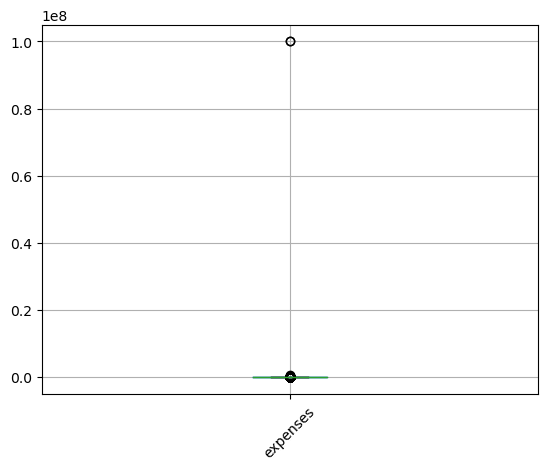

In [90]:
data.boxplot(column=list(num.columns)[5],rot=45) 
#plt.ylim(0, 0.6*1035) 

Una vez visualizamos los outliers, ajustamos la base para predecir sin tener en cuenta esos valores extremos y revisamos cuantos datos perderiamos de esta forma.

In [93]:
pd.Series(data.surface_covered_in_m2).value_counts().sort_values()
print(len(data[data["surface_covered_in_m2"]>400])/len(data))

0.002882857544649135


In [268]:
pd.Series(data.rooms).value_counts().sort_values()

77.0        1
647.0       1
102.0       1
136.0       1
2290.0      1
         ... 
5.0       134
4.0       298
3.0       677
1.0       972
2.0       972
Name: rooms, Length: 195, dtype: int64

In [269]:
data=data[(data.floor<30) &(data.rooms<33)]
data.shape

(2992, 15)

Sacamos una matriz de correlación para observar el comportamiento entre variables

In [25]:
data.corr()

,lat,lon,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,price_usd_per_m2_median,price_per_m2_median
lat,1.000000e+00,8.729321e-01,8.295708e-02,6.706604e-02,1.360894e-02,3.728241e-02,8.297613e-02,-1.607586e-01,1.558284e-02,5.998386e-03,1.054662e-02,1.930419e-11,-1.929207e-11
lon,8.729321e-01,1.000000e+00,3.953146e-02,-6.617197e-03,-5.797038e-03,-2.788482e-02,6.858308e-02,-9.932526e-02,1.674647e-02,6.480414e-03,-3.506211e-03,-1.141384e-12,1.145469e-12
price_aprox_local_currency,8.295708e-02,3.953146e-02,1.000000e+00,1.000000e+00,1.972211e-03,1.884335e-01,7.090687e-01,5.603219e-02,-9.347364e-03,-1.805434e-02,-3.172078e-03,-1.293790e-15,1.907595e-15
price_aprox_usd,6.706604e-02,-6.617197e-03,1.000000e+00,1.000000e+00,7.043894e-03,3.288151e-01,4.433778e-01,4.307161e-02,-5.422454e-03,9.539341e-04,-2.050831e-03,2.573023e-16,9.740737e-16
surface_total_in_m2,1.360894e-02,-5.797038e-03,1.972211e-03,7.043894e-03,1.000000e+00,3.547927e-02,-2.383997e-03,-2.958646e-02,-6.239947e-04,-2.683495e-04,-4.838768e-04,4.625160e-16,-8.421181e-16
surface_covered_in_m2,3.728241e-02,-2.788482e-02,1.884335e-01,3.288151e-01,3.547927e-02,1.000000e+00,-4.028160e-02,-2.009401e-01,-6.531198e-03,1.087580e-02,2.133419e-02,9.366273e-16,-4.173296e-16
price_usd_per_m2,8.297613e-02,6.858308e-02,7.090687e-01,4.433778e-01,-2.383997e-03,-4.028160e-02,1.000000e+00,1.266074e-01,-5.877686e-03,-2.210381e-03,-1.875710e-03,2.712784e-14,-2.879873e-14
price_per_m2,-1.607586e-01,-9.932526e-02,5.603219e-02,4.307161e-02,-2.958646e-02,-2.009401e-01,1.266074e-01,1.000000e+00,1.874578e-02,5.558573e-03,-1.480264e-03,-1.090568e-13,1.037174e-13
floor,1.558284e-02,1.674647e-02,-9.347364e-03,-5.422454e-03,-6.239947e-04,-6.531198e-03,-5.877686e-03,1.874578e-02,1.000000e+00,5.034143e-01,-5.974930e-04,-1.273593e-15,1.567720e-16
rooms,5.998386e-03,6.480414e-03,-1.805434e-02,9.539341e-04,-2.683495e-04,1.087580e-02,-2.210381e-03,5.558573e-03,5.034143e-01,1.000000e+00,-2.846214e-04,4.098228e-16,6.631010e-16


Graficamos un mapa de calor para identificar cuales son las variables numericas que se relacionan más con el precio por metro cuadrado en dolares
Asi podemos ver que los datos que más se relacionan son: 

<AxesSubplot:>

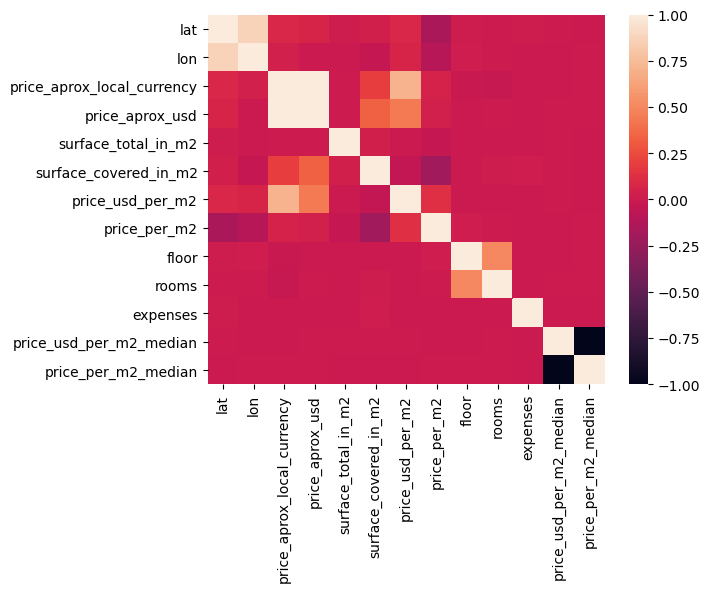

In [26]:
sns.heatmap(data.corr())

Ahora creamos un grupo de variables categoricas empleando. describe de tipo Object.

In [28]:
cat=data.describe(include=[object])  
cat

,property_type,place_name,place_with_parent_names,lat-lon,ciudad_chica,expenses_category
count,5531,5531,5531,5531,5531,5531
unique,4,1,1,1761,1,4
top,apartment,Rosario,|Argentina|Santa Fe|Rosario|,"-33.16667,-60.75",Rosario,Sin Expensas
freq,4703,5531,5531,2452,5531,5299


Calculamos la media de las variables numericas tomando como base las variables **categoricas y las organizamos para poder hacer un analisis general
Lo que podemos ver en este analisis es que  ***por ejemplo que :xxx**

In [29]:
grpmean=data.groupby(list(cat.columns)).mean().sort_values(by=['price_usd_per_m2'])
grpmean[['price_usd_per_m2','floor', 'rooms', 'surface_total_in_m2', 'surface_covered_in_m2','expenses','lat', 'lon']]

price_usd_per_m2  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category                     
apartment     Rosario    |Argentina|Santa Fe|Rosario| -32.9739762,-60.7344839         Rosario      Sin Expensas              62.813697   
                                                      -38.416097,-63.616672           Rosario      Sin Expensas              84.847636   
                                                      -32.953517100000006,-60.6486556 Rosario      Sin Expensas             109.877882   
                                                      -32.952805600000005,-60.6397661 Rosario      Sin Expensas             132.221067   
                                                      -32.9816814,-60.6585999         Rosario      Sin Expensas             138.540500   
...                                                                                                                                ...   
                                                      -32.9631876,-60.655396200000006 Rosario      Sin Expensas           33883.559122   
                                                      -32.9294903,-60.6743257         Rosario      Sin Expensas           40091.463415   
                                                      -32.9572895,-60.645358400000006 Rosario      Sin Expensas           42500.000000   
                                                      -32.9351434,-60.649730700000006 Rosario      Sin Expensas           44425.675676   
store         Rosario    |Argentina|Santa Fe|Rosario| -32.9405959,-60.6652259         Rosario      Sin Expensas           57382.080000   

                                                                                                                            floor  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category                
apartment     Rosario    |Argentina|Santa Fe|Rosario| -32.9739762,-60.7344839         Rosario      Sin Expensas       6639.000000   
                                                      -38.416097,-63.616672           Rosario      Sin Expensas          1.000000   
                                                      -32.953517100000006,-60.6486556 Rosario      Sin Expensas          1.500000   
                                                      -32.952805600000005,-60.6397661 Rosario      Sin Expensas          3.000000   
                                                      -32.9816814,-60.6585999         Rosario      Sin Expensas          2.000000   
...                                                                                                                           ...   
                                                      -32.9631876,-60.655396200000006 Rosario      Sin Expensas          9.666667   
                                                      -32.9294903,-60.6743257         Rosario      Sin Expensas         53.000000   
                                                      -32.9572895,-60.645358400000006 Rosario      Sin Expensas               NaN   
                                                      -32.9351434,-60.649730700000006 Rosario      Sin Expensas         45.000000   
store         Rosario    |Argentina|Santa Fe|Rosario| -32.9405959,-60.6652259         Rosario      Sin Expensas          1.000000   

                                                                                                                            rooms  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category                
apartment     Rosario    |Argentina|Santa Fe|Rosario| -32.9739762,-60.7344839         Rosario      Sin Expensas       6639.000000   
                                                      -38.416097,-63.616672           Rosario      Sin Expensas          2.000000   
                                                      -32.953

Tambien chequeamos cuantos datos tenemos en esa distribución

In [30]:
data.groupby(list(cat.columns)).count()

lat  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category        
PH            Rosario    |Argentina|Santa Fe|Rosario| -32.872,-60.69321899999999      Rosario      Sin Expensas         1   
                                                      -32.8851413,-60.7004005         Rosario      Sin Expensas         1   
                                                      -32.9154223,-60.6753003         Rosario      Expensas Bajas       1   
                                                      -32.920214,-60.734997           Rosario      Sin Expensas         1   
                                                      -32.9331794,-60.7210645         Rosario      Sin Expensas         1   
...                                                                                                                   ...   
store         Rosario    |Argentina|Santa Fe|Rosario| -32.973620399999994,-60.6434328 Rosario      Sin Expensas         1   
                                                      -32.978008,-60.662029           Rosario      Sin Expensas         1   
                                                      -33.16667,-60.75                Rosario      Expensas Bajas       3   
                                                                                                   Expensas Normales    2   
                                                                                                   Sin Expensas        66   

                                                                                                                      lon  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category        
PH            Rosario    |Argentina|Santa Fe|Rosario| -32.872,-60.69321899999999      Rosario      Sin Expensas         1   
                                                      -32.8851413,-60.7004005         Rosario      Sin Expensas         1   
                                                      -32.9154223,-60.6753003         Rosario      Expensas Bajas       1   
                                                      -32.920214,-60.734997           Rosario      Sin Expensas         1   
                                                      -32.9331794,-60.7210645         Rosario      Sin Expensas         1   
...                                                                                                                   ...   
store         Rosario    |Argentina|Santa Fe|Rosario| -32.973620399999994,-60.6434328 Rosario      Sin Expensas         1   
                                                      -32.978008,-60.662029           Rosario      Sin Expensas         1   
                                                      -33.16667,-60.75                Rosario      Expensas Bajas       3   
                                                                                                   Expensas Normales    2   
                                                                                                   Sin Expensas        66   

                                                                                                                      price_aprox_local_currency  \
property_type place_name place_with_parent_names      lat-lon                         ciudad_chica expenses_category                               
PH            Rosario    |Argentina|Santa Fe|Rosario| -32.872,-60.69321899999999      Rosario      Sin Expensas                                1   
                                                      -32.8851413,-60.7004005         Rosario      Sin Expensas                                1   
                                                      -32.9154223,-60.6753003         Rosario      Expensas Bajas                              1   
                                                      -32.920214,-60.734997           Rosario      Sin Expensas               

In [31]:
num.columns

Index(['lat', 'lon', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'price_usd_per_m2_median',
       'price_per_m2_median'],
      dtype='object')

In [32]:
data=data.dropna()
print(data.shape)

(1983, 19)


Index(['lat', 'lon', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms',
       ...
       'lat-lon_-33.077914,-60.570331',
       'lat-lon_-33.113853000000006,-60.707264',
       'lat-lon_-33.1489771508,-60.4886835792', 'lat-lon_-33.16667,-60.75',
       'lat-lon_-38.416097,-63.616672', 'ciudad_chica_Rosario',
       'expenses_category_Expensas Altas', 'expenses_category_Expensas Bajas',
       'expenses_category_Expensas Normales',
       'expenses_category_Sin Expensas'],
      dtype='object', length=847)

Generamos variables dummies 

In [33]:
dtm=pd.get_dummies(data)
dtm.columns

Index(['lat', 'lon', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms',
       ...
       'lat-lon_-33.077914,-60.570331',
       'lat-lon_-33.113853000000006,-60.707264',
       'lat-lon_-33.1489771508,-60.4886835792', 'lat-lon_-33.16667,-60.75',
       'lat-lon_-38.416097,-63.616672', 'ciudad_chica_Rosario',
       'expenses_category_Expensas Altas', 'expenses_category_Expensas Bajas',
       'expenses_category_Expensas Normales',
       'expenses_category_Sin Expensas'],
      dtype='object', length=847)

Seleccionamos las variables o features con las que haremos el modelo: **surface_total_in_m2, surface_covered_in_m2,floor, rooms, expenses, property_type_PH, property_type_apartment, property_type_house, property_type_store**  

Definimos las variables del modelo

In [35]:
featcol=['lat', 'lon', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'price_usd_per_m2_median',
       'price_per_m2_median', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store',
       'expenses_category_Expensas Bajas',
       'expenses_category_Expensas Normales',
       'expenses_category_Sin Expensas']
x=dtm[featcol]
y=dtm[['price_usd_per_m2']]

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())




                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     170.6
Date:                Tue, 01 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:59:00   Log-Likelihood:                -19088.
No. Observations:                1983   AIC:                         3.821e+04
Df Residuals:                    1966   BIC:                         3.831e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
la

**Lo que podemos interpretar de estos datos es que: **el s2 nos arroja un resultado de 57.8% lo que significa ** 
**Adicionalmente, vemos que el pvalue por debajo de 0,25 y que podemos emplear para modelar de mejor manera son : suface covered in m2, .....**
**Debemos completar el analisis en este punto**

Ahora corremos el modelo con las variables con un pvalue más significativo

In [36]:
featcol1=[ 'price_aprox_local_currency', 'price_aprox_usd',
        'surface_covered_in_m2',
       'price_per_m2', 'floor', 'rooms', 
       'property_type_house', 'property_type_store']
x1=dtm[featcol1]
y=dtm[['price_usd_per_m2']]
model1 = sm.OLS(y, x1)
results1 = model1.fit()
print(results1.summary())

                                 OLS Regression Results                                
Dep. Variable:       price_usd_per_m2   R-squared (uncentered):                   0.648
Model:                            OLS   Adj. R-squared (uncentered):              0.647
Method:                 Least Squares   F-statistic:                              455.3
Date:                Tue, 01 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:04:12   Log-Likelihood:                         -19133.
No. Observations:                1983   AIC:                                  3.828e+04
Df Residuals:                    1975   BIC:                                  3.833e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

**Al correr el modelo con los valores de pvalue seleccionadas, vemos que el modelo arroja un mejor resultado en el s2 ajustado  de 64.7.8% lo que significa ** 
**Adicionalmente, vemos que el pvalue por debajo de 0,25 y que podemos emplear para modelar de mejor manera son : suface covered in m2, .....**
**Debemos completar el analisis en este punto**

In [281]:
featcol2=[ 'price_aprox_local_currency', 'price_aprox_usd',
        'surface_covered_in_m2',
       'price_per_m2', 'floor', 'rooms', 
        'property_type_store']
x2=dtm[featcol2]
y=dtm[['price_usd_per_m2']]
model2 = sm.OLS(y, x2)
results2 = model2.fit()
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:       price_usd_per_m2   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.656
Method:                 Least Squares   F-statistic:                              398.3
Date:                Sun, 30 Oct 2022   Prob (F-statistic):                        0.00
Time:                        19:53:56   Log-Likelihood:                         -14132.
No. Observations:                1460   AIC:                                  2.828e+04
Df Residuals:                    1453   BIC:                                  2.832e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [282]:
featcol3=[ 'lat', 'lon',
        'floor', 'rooms']
x3=dtm[featcol3]
y=dtm[['price_usd_per_m2']]
model3 = sm.OLS(y, x3)
results3 = model3.fit()
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:       price_usd_per_m2   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.202
Method:                 Least Squares   F-statistic:                              93.53
Date:                Sun, 30 Oct 2022   Prob (F-statistic):                    7.47e-71
Time:                        19:53:56   Log-Likelihood:                         -14747.
No. Observations:                1460   AIC:                                  2.950e+04
Df Residuals:                    1456   BIC:                                  2.952e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [283]:


x4 = sm.add_constant(x2)
y=dtm[['price_usd_per_m2']]
model4 = sm.OLS(y, x4)
results4 = model4.fit()
print(results4.summary())


                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     306.6
Date:                Sun, 30 Oct 2022   Prob (F-statistic):          8.27e-281
Time:                        19:53:56   Log-Likelihood:                -14096.
No. Observations:                1460   AIC:                         2.821e+04
Df Residuals:                    1452   BIC:                         2.825e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [284]:
dtm1=data.dropna()
dtm1.reset_index(inplace=True)
cat1=dtm1[["property_type",	"expenses_category"]][:]
cat1.expenses_category.unique()

array(['Sin Expensas', 'Expensas Bajas', 'Expensas Normales'],
      dtype=object)

In [285]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
dtm1=ss.fit_transform(dtm1[num.columns])
dtm1=pd.DataFrame(dtm1,columns=list(num.columns))
dtm1["property_type"]=cat1["property_type"]
dtm1["expenses_category"]=cat1["expenses_category"]
dtm1.head()

,lat,lon,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,price_usd_per_m2_median,price_per_m2_median,property_type,expenses_category
0,0.190574,0.396372,-0.291808,-0.291808,-0.027307,-0.573870,-0.147640,0.868876,-0.490034,-0.514641,-0.138678,0.0,0.0,apartment,Sin Expensas
1,0.285003,0.567057,-0.183901,-0.183901,-0.025565,-0.527272,-0.320487,2.200291,-0.490034,-0.514641,-0.138678,0.0,0.0,apartment,Sin Expensas
2,0.259238,0.127043,-0.319284,-0.319284,-0.027118,-0.511740,-0.272557,0.280823,-0.490034,-0.514641,-0.138678,0.0,0.0,apartment,Sin Expensas
3,0.314594,-1.631107,0.473076,0.473076,-0.005262,3.837424,-0.211707,-1.207216,-0.049305,-0.011488,-0.138678,0.0,0.0,house,Sin Expensas
4,0.236979,0.003846,0.275536,0.275536,-0.007534,5.080043,-0.431968,-1.239450,-0.049305,-0.011488,-0.138678,0.0,0.0,house,Sin Expensas


In [286]:
dtm1=pd.get_dummies(dtm1)
dtm1.columns

Index(['lat', 'lon', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'price_usd_per_m2_median',
       'price_per_m2_median', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store',
       'expenses_category_Expensas Bajas',
       'expenses_category_Expensas Normales',
       'expenses_category_Sin Expensas'],
      dtype='object')

In [288]:
x5=dtm1[featcol]
y1=dtm1[['price_usd_per_m2']]
model5 = sm.OLS(y1, x5)
results5 = model5.fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     143.5
Date:                Sun, 30 Oct 2022   Prob (F-statistic):          4.74e-273
Time:                        19:54:39   Log-Likelihood:                -1405.3
No. Observations:                1460   AIC:                             2843.
Df Residuals:                    1444   BIC:                             2927.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
la

In [291]:
featcol6=[ 'price_aprox_local_currency', 'price_aprox_usd',
        'surface_covered_in_m2', 
       'price_per_m2', 'floor', 'rooms',  'price_usd_per_m2_median',
       'price_per_m2_median', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store',
       'expenses_category_Expensas Bajas',
       'expenses_category_Expensas Normales',
       'expenses_category_Sin Expensas']
x6=dtm1[featcol6]
y1=dtm1[['price_usd_per_m2']]
model6 = sm.OLS(y1, x6)
results6 = model6.fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     196.1
Date:                Sun, 30 Oct 2022   Prob (F-statistic):          1.98e-277
Time:                        19:59:22   Log-Likelihood:                -1405.7
No. Observations:                1460   AIC:                             2835.
Df Residuals:                    1448   BIC:                             2899.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
pr